# tdsm encoder
Here we provide interactive scripts, with which one can study input features, hyperparameters and finally perform the training & sampling of generative model. All of these scripts use classes and functions used in the code that runs on condor in order to obtain the optimised model trained on the full dataset. We advise not to train the model on the full dataset here as it will take too long. We advise to limit the training dataset size and number of epochs and use this notebook to study pre-processing, hyperparameters and diffusion techniques.

## import model

In [2]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import trans_tdsm, utils
from prettytable import PrettyTable
import util.dataset_structure, util.display, util.model
import tqdm
from pickle import load
from IPython import display

device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_value = -20

dataset = "dataset_1_photons_padded_nentry"
dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/"
transform = None
transform_y = None
mask = True
jupyternotebook = True

workingdir = "./"
### HYPERPARAMETERS ###
train_ratio = 0.8
batch_size = 64
lr = 0.00001
n_epochs = 25
### SDE PARAMETERS ###
SDE = 'VE'
sigma_max = 50.
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 3
num_attn_heads = 8
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = utils.VPSDE(beta_max=sigma_max,device=device)
if SDE == 'VE':
    sde = utils.VESDE(sigma_max=sigma_max,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    #if fnmatch.fnmatch(filename, dataset + '12*.pt') or fnmatch.fnmatch(filename, dataset + '21*.pt') or fnmatch.fnmatch(filename, dataset + '30*.pt'):
    if fnmatch.fnmatch(filename, dataset + '12*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

model=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)

table = PrettyTable(['Module name', 'Parameters listed'])
t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    table.add_row([name_, param])
    t_params+=param
print(table)
print(f'Sum of trainable parameters: {t_params}')    

torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.2
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['/eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt']
+--------------------------------+-------------------+
|          Module name           | Parameters listed |
+--------------------------------+-------------------+
|           cls_token            |        512        |
|          embed.weight          |        2048       |
|           embed.bias           |        512        |
|        embed_t.1.weight        |       262144      |
|         embed_t.1.bias         |        512        |
|      dense1.dense.weight       |        512        |
|       dense1.dense.bias        |         1         |
| encoder.0.attn.in_proj_weight  |       786432      |
|  encoder.0.attn.in_proj_bias   |        1536       |


## Plot data distribution

Display distributions of either the transformed or non-transformed input features. This is one way of inspecting how the transformation is affecting the distributions input to the training. Transforming data is an important part of the pre-processing stage of machine learning projects. We want to ensure that the input features have distributions that are as easy as possible for the machine learning algorithm to learn and that features have a similar numerical range, to avoid the task of loss minimisation shifting focus to a single variable. One commonly used way of doing this is to transform variables to have a Gaussian like distribution. In order to choose the transformation function that is best for your data, it is important to study the data and how the transformation affects your distributions. Note that pre-processing data can be one of the most time consuming aspects of a machine learning project and can have a profound affect on the success of the project, so take your time here.

Training is always performed using the transformed inputs where available. The `energy_trans_file` argument should be the pickle file containing fitted input transformation function. Only provide a file name if you want to plot distributions where the transformation has been inverted and applied to inputs to transform back to the original distributions. In such cases, if you want to check the inverted transformation is doing the correct inversion, compare for a single file against the plots inside the directory:

`
datasets/<transformation>/featureplots_dataset
`

Plots of the inverted transformation should be similar to what is shown in those, though not identical as we only plot a subset of the showers.

### Effects of transformations
#### Quantile Gaussian transformation:
Non-linear transformation that maps the probability denity function of each feature to a uniform Gaussian distribution, including outliers. Lower numbers become smaller and eventually negative.

plot_distribution running on input type 'files'
n_files <class 'int'>: 3
# showers <class 'int'> to plot: 100
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry211To240.pt
# batches: 8917
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry301To330.pt
# batches: 28518
Plot # entries
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy per shower
Plot av. X position per shower
Plot av. Y position per shower


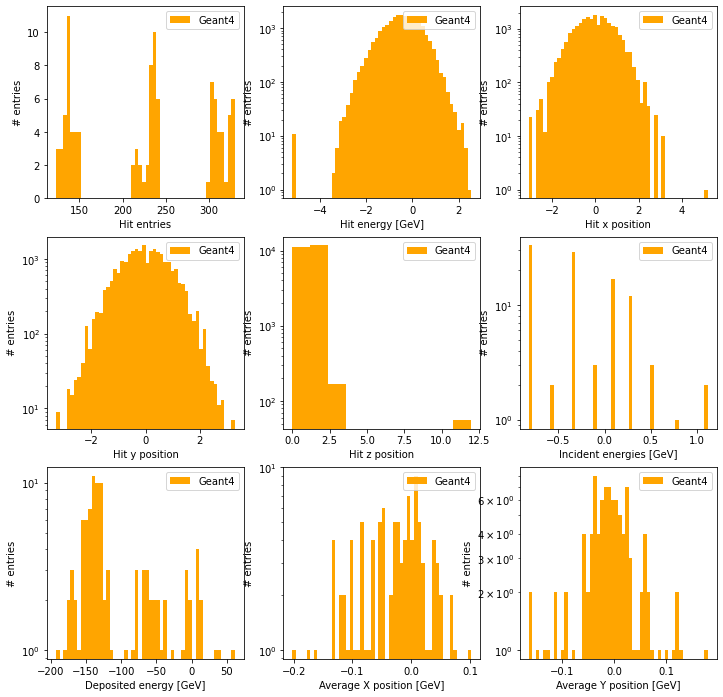

In [2]:
# Non-transformed variables
'''
dists = util.display.plot_distribution(files_list_,energy_trans_file='transform_e.pkl', x_trans_file='transform_x.pkl', y_trans_file='transform_y.pkl', ine_trans_file='rescaler_y.pkl')
entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine = dists[7]
average_x_shower = dists[8]
average_y_shower = dists[9]
'''

# Transformed variables
dists_trans = util.display.plot_distribution(files_list_, nshowers_2_plot=100)
entries = dists_trans[0]
all_incident_e_trans = dists_trans[1]
total_deposited_e_shower_trans = dists_trans[2]
all_e_trans = dists_trans[3]
all_x_trans = dists_trans[4]
all_y_trans = dists_trans[5]
all_z_trans = dists_trans[6]
all_hit_ine_trans = dists_trans[7]
average_x_shower_trans = dists_trans[8]
average_y_shower_trans = dists_trans[9]

fig, ax = plt.subplots(3,3, figsize=(12,12))
print('Plot # entries')
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 50, color='orange', label='Geant4')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e_trans, 50, color='orange', label='Geant4')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x_trans, 50, color='orange', label='Geant4')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y_trans, 50, color='orange', label='Geant4')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z_trans, color='orange', label='Geant4')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e_trans, 50, color='orange', label='Geant4')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy per shower')
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower_trans, 50, color='orange', label='Geant4')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot av. X position per shower')
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Average X position [GeV]')
ax[2][1].hist(average_x_shower_trans, 50, color='orange', label='Geant4')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot av. Y position per shower')
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Average Y position [GeV]')
ax[2][2].hist(average_y_shower_trans, 50, color='orange', label='Geant4')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()
save_name = os.path.join(dataset_store_path,'input_dists_transformed.png')
fig.savefig(save_name)

## 2D distributions
Requires variables from the above cell

plot_distribution running on input type 'files'
Loading file for hit e transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/transform_e.pkl
Loading file for hit x transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/transform_x.pkl
Loading file for hit y transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/transform_y.pkl
Loading file for incident e transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/rescaler_y.pkl
n_files <class 'int'>: 3
# showers <class 'int'> to plot: 100
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry211To240.pt
# batches: 8917
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer

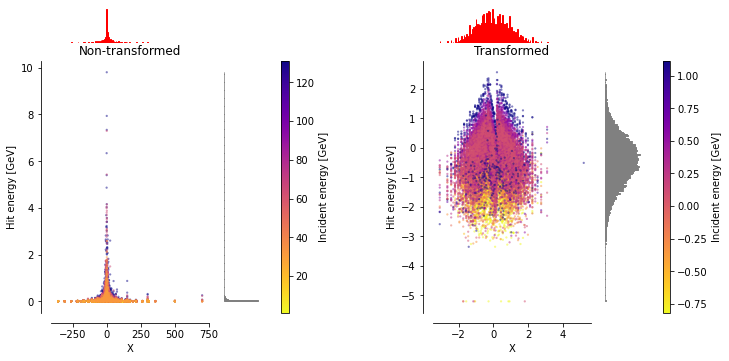

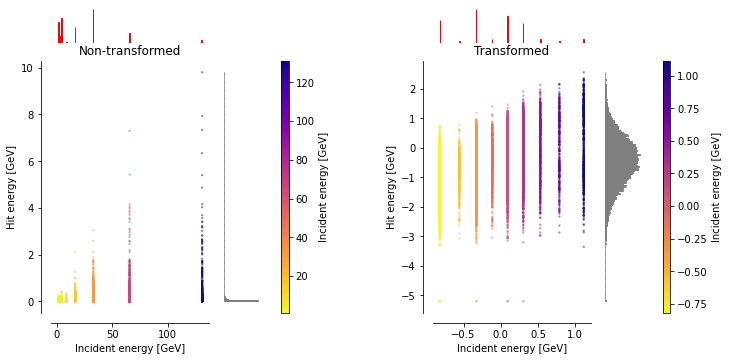

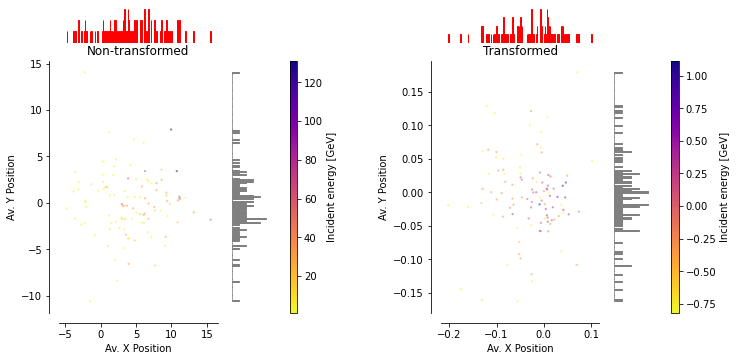

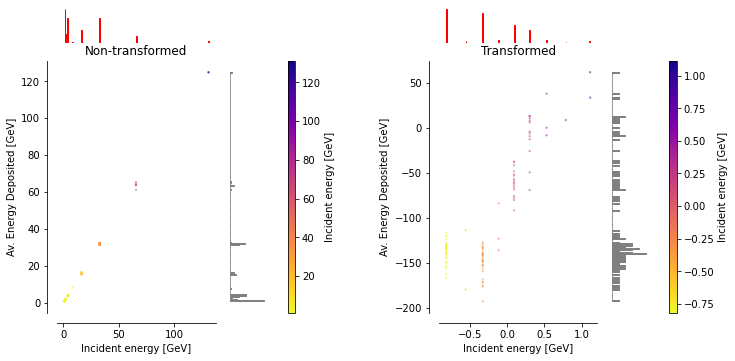

In [4]:
# Non-transformed variables
dists = util.display.plot_distribution(files_list_, nshowers_2_plot=100, energy_trans_file='transform_e.pkl', x_trans_file='transform_x.pkl', y_trans_file='transform_y.pkl', ine_trans_file='rescaler_y.pkl')
entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine = dists[7]
average_x_shower = dists[8]
average_y_shower = dists[9]

distributions = [(('X', 'Hit energy [GeV]', 'Incident energy [GeV]') , (all_x, all_e, all_hit_ine, all_x_trans, all_e_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('Incident energy [GeV]', 'Hit energy [GeV]', 'Incident energy [GeV]') , (all_hit_ine, all_e, all_hit_ine, all_hit_ine_trans, all_e_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('Av. X Position', 'Av. Y Position', 'Incident energy [GeV]') , (average_x_shower, average_y_shower, all_incident_e, average_x_shower_trans, average_y_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Incident energy [GeV]', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (all_incident_e, total_deposited_e_shower, all_incident_e, all_incident_e_trans, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)


## Training

Training is performed now on the transformed input features, therefore the generated samples will also be in the transformed feature space

  0%|          | 0/25 [00:00<?, ?it/s]

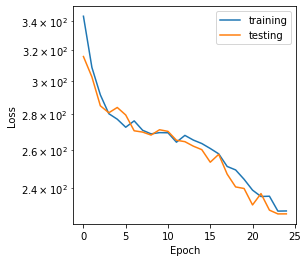

['/eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt']


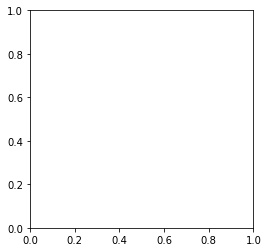

In [12]:
output_directory = workingdir+'/training_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
            os.makedirs(output_directory)
optimiser = RAdam(model.parameters(),lr=lr)
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
epochs = tqdm.notebook.trange(n_epochs)
dh = display.display(fig, display_id=True)

print(files_list_)

for epoch in epochs:

    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(train_ratio * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])

        n_training_showers+=train_size
        n_testing_showers+=test_size
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)
        
        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model.to(device, shower_data.dtype)
            model.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)
            
            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            #loss.backward(retain_graph=True)
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()
            
        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
                cumulative_test_epoch_loss+=float(test_loss)
    
    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch))
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(av_training_losses_per_epoch, label='training')
    plt.plot(av_testing_losses_per_epoch, label='testing')
    plt.legend(loc='upper right')
    dh.update(fig)
    if epoch == n_epochs:
        fig.savefig(output_directory+'loss_v_epoch.png')

torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')


## Sampling 

batch_size: 64
Files: ['/eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt']


/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:557: RuntimeWarning:

invalid value encountered in true_divide



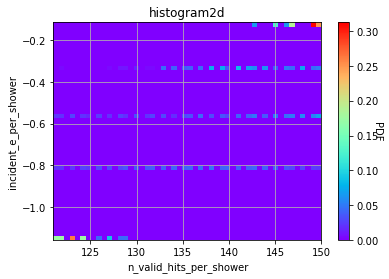

# batches: 4
Generation batch 0: showers per batch: 64, max. hits per shower: 150, features per hit: 4, sampled_energies: 64
Progress: 1/4

  0%|          | 0/100 [00:00<?, ?it/s]

Loading file for hit e transformation inversion: 
sample: torch.Size([64, 150, 4])
Generation batch 1: showers per batch: 64, max. hits per shower: 150, features per hit: 4, sampled_energies: 64
Progress: 2/4

  0%|          | 0/100 [00:00<?, ?it/s]

Loading file for hit e transformation inversion: 
sample: torch.Size([128, 150, 4])
Generation batch 2: showers per batch: 64, max. hits per shower: 150, features per hit: 4, sampled_energies: 64
Progress: 3/4

  0%|          | 0/100 [00:00<?, ?it/s]

Loading file for hit e transformation inversion: 
sample: torch.Size([192, 150, 4])
Generation batch 3: showers per batch: 8, max. hits per shower: 150, features per hit: 4, sampled_energies: 8
Progress: 4/4

  0%|          | 0/100 [00:00<?, ?it/s]

Loading file for hit e transformation inversion: 
sample: torch.Size([200, 150, 4])


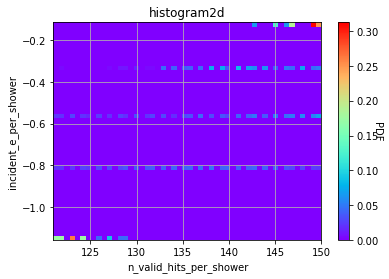

In [13]:
from IPython import display
from datetime import datetime
import functools, torch, os, sys, random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
workingdir = "./"

# SAMPLE PARAMETERS
sampler_steps = 100
n_showers_2_gen =  200

print(f'batch_size: {batch_size}')

output_directory = workingdir+'/sampling_'+str(sampler_steps)+'samplersteps_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load saved model
model.load_state_dict(torch.load('training_20230725_1712_output/ckpt_tmp_24.pth', map_location=device))
model.to(device)

# Get max. N hits / N valid hits in batch
n_valid_hits_per_shower = []
incident_e_per_shower = []
geant_deposited_energy = []
geant_x_pos = []
geant_y_pos = []
geant_ine = []
N_geant_showers = 0

max_hits = -1
print(f'Files: {files_list_}')

# For diffusion plots in 'physical' feature space, add files here
energy_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_e.pkl')
x_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_x.pkl')
y_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_y.pkl')
ine_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'rescaler_y.pkl')

# Load saved pre-processor
if ine_trans_file != '':
    print(f'energy_trans_file: {energy_trans_file}')
    scalar_ine = load(open(ine_trans_file, 'rb'))
if energy_trans_file != '':
    scalar_e = load(open(energy_trans_file, 'rb'))
if x_trans_file != '':
    scalar_x = load(open(x_trans_file, 'rb'))
if y_trans_file != '':
    scalar_y = load(open(y_trans_file, 'rb'))

for file in files_list_:
    # Load shower data
    custom_data = utils.cloud_dataset(file, device=device)
    point_clouds_loader = DataLoader(custom_data, batch_size=batch_size, shuffle=False)
    # Loop over batches
    for i, (shower_data, incident_energies) in enumerate(point_clouds_loader,0):

        # Copy data
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        energy_np = incident_energies.cpu().numpy().copy()

        # Mask for padded values
        masking = data_np[:,:,0] != -20
        
        # Loop over each shower in batch
        for j in range(len(data_np)):
            # Mask padded hits and count valid hits for shower j in batch
            valid_hits = data_np[j][masking[j]]
            n_valid_hits_per_shower.append(len(valid_hits))
            if len(valid_hits)>max_hits:
                max_hits = len(valid_hits)
            incident_e_per_shower.append(energy_np[j])

            # ONLY for plotting purposes
            if N_geant_showers < n_showers_2_gen:
                all_ine = np.array(energy_np[j]).reshape(-1,1)
                # Rescale the conditional input for each shower
                if ine_trans_file != '':
                    all_ine = scalar_ine.inverse_transform(all_ine)
                all_ine = all_ine.flatten().tolist()
                geant_ine.append(all_ine)
                
                all_e = valid_hits[:,0].reshape(-1,1)
                if energy_trans_file != '':
                    all_e = scalar_e.inverse_transform(all_e)
                all_e = all_e.flatten().tolist()
                geant_deposited_energy.append( sum( all_e ) )
                
                all_x = valid_hits[:,1].reshape(-1,1)
                if x_trans_file != '':
                    all_x = scalar_x.inverse_transform(all_x)
                all_x = all_x.flatten().tolist()
                geant_x_pos.append( np.mean(all_x) )
                
                all_y = valid_hits[:,2].reshape(-1,1)
                if y_trans_file != '':
                    all_y = scalar_y.inverse_transform(all_y)
                all_y = all_y.flatten().tolist()
                geant_y_pos.append( np.mean(all_y) )

            N_geant_showers+=1
    del custom_data
    
# Arrays of Nvalid hits in showers, incident energies per shower
n_valid_hits_per_shower = np.array(n_valid_hits_per_shower)
incident_e_per_shower = np.array(incident_e_per_shower)
max_incident_e = max(incident_e_per_shower)
min_incident_e = min(incident_e_per_shower)

# Generate 2D pdf of incident E vs N valid hits from the training file(s)
n_bins_prob_dist = 50
e_vs_nhits_prob, x_bin, y_bin = trans_tdsm.get_prob_dist(incident_e_per_shower, n_valid_hits_per_shower, n_bins_prob_dist)

# Plot 2D histogram (sanity check)
fig0, (ax0) = plt.subplots(ncols=1, sharey=True)
dh0 = display.display(fig0, display_id=True)
heatmap = ax0.pcolormesh(y_bin, x_bin, e_vs_nhits_prob, cmap='rainbow')
ax0.plot(n_valid_hits_per_shower, n_valid_hits_per_shower, 'k-')
ax0.set_xlim(n_valid_hits_per_shower.min(), n_valid_hits_per_shower.max())
ax0.set_ylim(incident_e_per_shower.min(), incident_e_per_shower.max())
ax0.set_xlabel('n_valid_hits_per_shower')
ax0.set_ylabel('incident_e_per_shower')
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('PDF', rotation=270)
ax0.set_title('histogram2d')
ax0.grid()
dh0.update(fig0)

# Generate tensor sampled from the appropriate range of injection energies
idx_list_incident_e = torch.randint(0, len(incident_e_per_shower), (n_showers_2_gen,))
in_energies = np.random.choice( incident_e_per_shower, n_showers_2_gen )
in_energies = torch.from_numpy(in_energies)

# Sample from 2D pdf = nhits per shower vs incident energies -> nhits and a tensor of randomly initialised hit features
nhits, gen_hits = trans_tdsm.generate_hits(e_vs_nhits_prob, x_bin, y_bin, in_energies, max_hits, 4, device=device)

# Save
torch.save([gen_hits, in_energies],'tmp.pt')

# Load the showers of noise
gen_hits = utils.cloud_dataset('tmp.pt', device=device)
# Pad showers
gen_hits.padding(padding_value)
# Load len(gen_hits_loader) number of batches each with batch_size number of showers
gen_hits_loader = DataLoader(gen_hits, batch_size=batch_size, shuffle=False)

# Remove noise shower file
os.system("rm tmp.pt")

# Instantiate sampler
sample = []
pc_sampler = trans_tdsm.pc_sampler(snr=0.16, sampler_steps=sampler_steps, device=device, jupyternotebook=True)

# Loop over each batch of noise showers
print(f'# batches: {len(gen_hits_loader)}' )
for i, (gen_hit, sampled_energies) in enumerate(gen_hits_loader,0):
    
    print(f'Generation batch {i}: showers per batch: {gen_hit.shape[0]}, max. hits per shower: {gen_hit.shape[1]}, features per hit: {gen_hit.shape[2]}, sampled_energies: {len(sampled_energies)}')    
    sys.stdout.write('\r')
    sys.stdout.write("Progress: %d/%d" % ((i+1), len(gen_hits_loader)))
    sys.stdout.flush()
    
    # Run reverse diffusion sampler
    generative = pc_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, sampled_energies, gen_hit, batch_size=gen_hit.shape[0], energy_trans_file=energy_trans_file, x_trans_file=x_trans_file , y_trans_file = y_trans_file, ine_trans_file=ine_trans_file)
    
    # Create first sample or concatenate sample to sample list
    if i == 0:
        sample = generative
    else:
        sample = torch.cat([sample,generative])
    
    print(f'sample: {sample.shape}')
    
sample_ = []
sample_np = sample.cpu().numpy()

for i in range(len(sample_np)):
    tmp_sample = sample_np[i][:nhits[i]]
    sample_.append(torch.tensor(tmp_sample))
torch.save([sample_,in_energies], os.path.join(output_directory, 'sample.pt'))


## Studying the diffusion

No we make some plots of our various features in order to study how the diffusion affects our predicitions

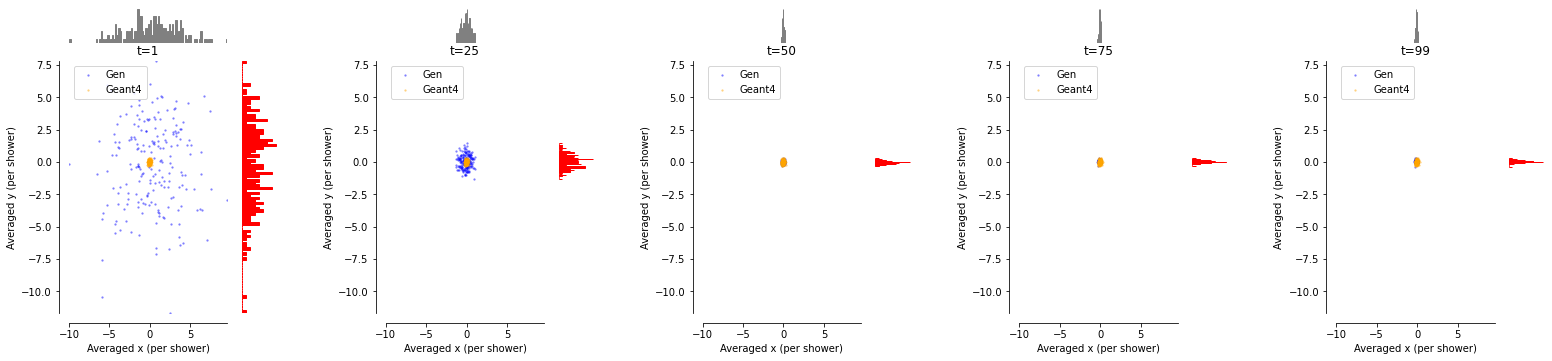

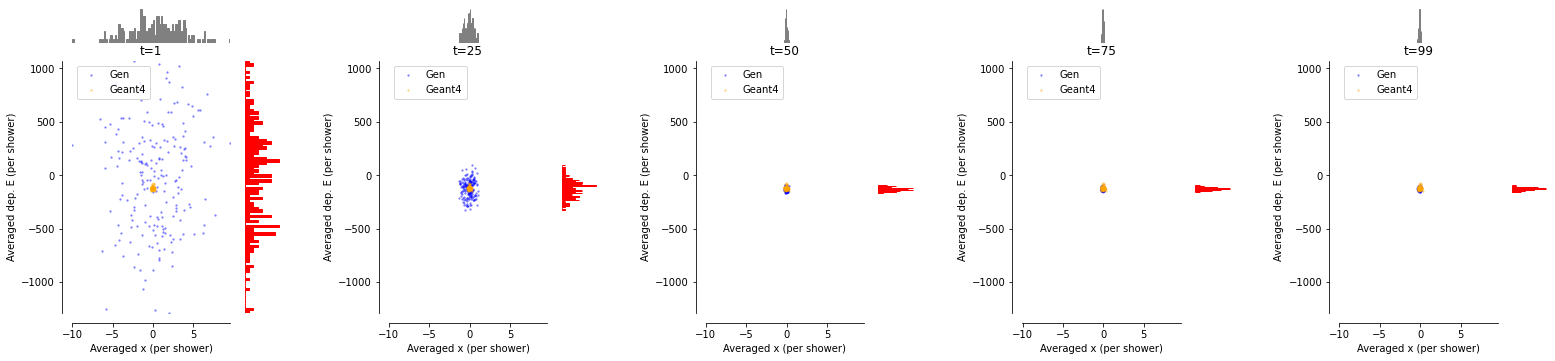

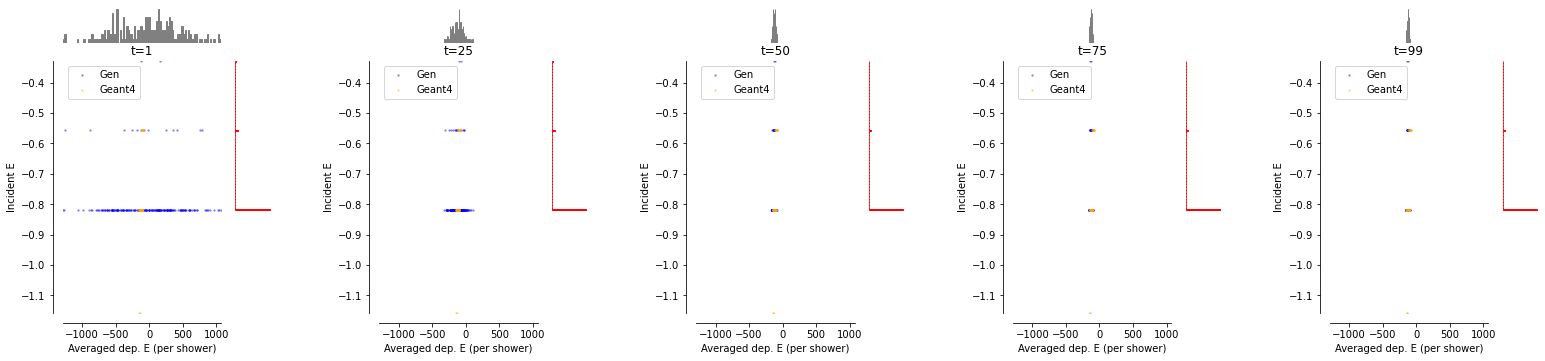

In [14]:
if jupyternotebook:
    
    # Create plots of distributions evolving with diffusion steps
    distributions = [
        geant_x_pos,
        geant_y_pos,
        pc_sampler.av_x_pos_t1,
        pc_sampler.av_y_pos_t1, 
        pc_sampler.av_x_pos_t25,
        pc_sampler.av_y_pos_t25,
        pc_sampler.av_x_pos_t50,
        pc_sampler.av_y_pos_t50,
        pc_sampler.av_x_pos_t75,
        pc_sampler.av_y_pos_t75,
        pc_sampler.av_x_pos_t99,
        pc_sampler.av_y_pos_t99,
    ]
    util.display.make_diffusion_plot(distributions, xlabel='Averaged x (per shower)', ylabel='Averaged y (per shower)')
    
    distributions = [
        geant_x_pos,
        geant_deposited_energy,
        pc_sampler.av_x_pos_t1,
        pc_sampler.deposited_energy_t1, 
        pc_sampler.av_x_pos_t25,
        pc_sampler.deposited_energy_t25,
        pc_sampler.av_x_pos_t50,
        pc_sampler.deposited_energy_t50,
        pc_sampler.av_x_pos_t75,
        pc_sampler.deposited_energy_t75,
        pc_sampler.av_x_pos_t99,
        pc_sampler.deposited_energy_t99,
    ]
    util.display.make_diffusion_plot(distributions, xlabel='Averaged x (per shower)', ylabel='Averaged dep. E (per shower)')
    
    distributions = [
        geant_deposited_energy,
        incident_e_per_shower[:n_showers_2_gen],
        pc_sampler.deposited_energy_t1,
        pc_sampler.incident_e_t1,
        pc_sampler.deposited_energy_t25,
        pc_sampler.incident_e_t25,
        pc_sampler.deposited_energy_t50,
        pc_sampler.incident_e_t50,
        pc_sampler.deposited_energy_t75,
        pc_sampler.incident_e_t75,
        pc_sampler.deposited_energy_t99,
        pc_sampler.incident_e_t99,
    ]
    util.display.make_diffusion_plot(distributions, xlabel='Averaged dep. E (per shower)', ylabel='Incident E')



## Draw Generative Distribution
We now comparisons of several features from the original GEANT4 dataset, and from showers generated in our diffusion model.

Generated inputs
plot_distribution running on input type 'cloud_dataset'
Geant4 inputs
plot_distribution running on input type 'files'
n_files <class 'int'>: 1
# showers <class 'int'> to plot: 200
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/quantile_gauss_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
Plot # entries
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy
Plot total deposited hit energy
Plot total deposited hit energy


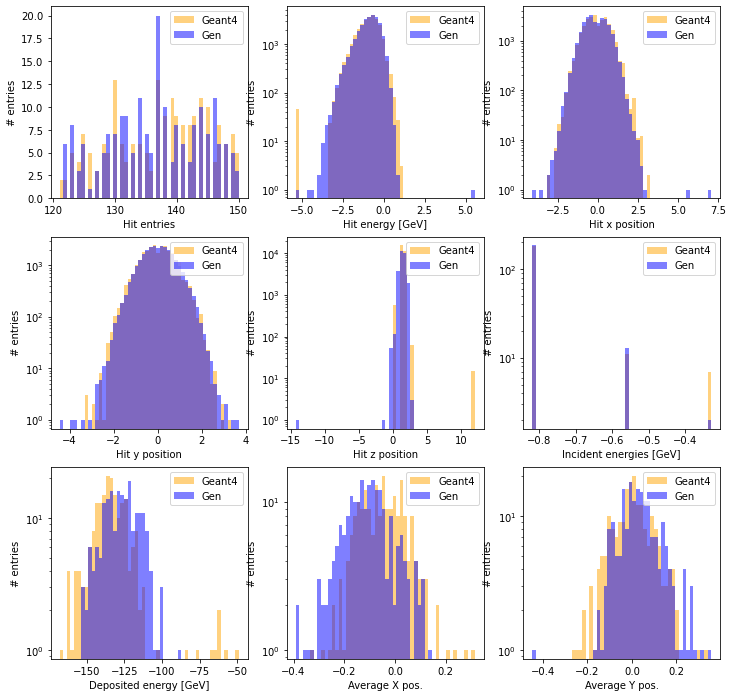

In [7]:
import utils, sys
#sys.path.insert(1, '../')
import util.display

n_showers_2_gen =  200

# Distributions object for generated files
print(f'Generated inputs')
output_directory = 'sampling_100samplersteps_20230725_1724_output'
plot_file_name = os.path.join(output_directory, 'sample.pt')
custom_data = utils.cloud_dataset(plot_file_name,device=device)
# when providing just cloud dataset, energy_trans_file needs to include full path
#dists_gen = util.display.plot_distribution(custom_data, energy_trans_file='/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/transform_e.pkl', nshowers_2_plot=n_showers_2_gen)
dists_gen = util.display.plot_distribution(custom_data, nshowers_2_plot=n_showers_2_gen)


entries_gen = dists_gen[0]
all_incident_e_gen = dists_gen[1]
total_deposited_e_shower_gen = dists_gen[2]
all_e_gen = dists_gen[3]
all_x_gen = dists_gen[4]
all_y_gen = dists_gen[5]
all_z_gen = dists_gen[6]
all_hit_ine_gen = dists_gen[7]
average_x_shower_gen = dists_gen[8]
average_y_shower_gen = dists_gen[9]

print(f'Geant4 inputs')
# Distributions object for Geant4 files
#dists = util.display.plot_distribution(files_list_, energy_trans_file='transform_e.pkl', nshowers_2_plot=n_showers_2_gen)
dists = util.display.plot_distribution(files_list_, nshowers_2_plot=n_showers_2_gen)

entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine_geant = dists[7]
average_x_shower_geant = dists[8]
average_y_shower_geant = dists[9]

print('Plot # entries')
bins=np.histogram(np.hstack((entries,entries_gen)), bins=50)[1]
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][0].hist(entries_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
bins=np.histogram(np.hstack((all_e,all_e_gen)), bins=50)[1]
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][1].hist(all_e_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
bins=np.histogram(np.hstack((all_x,all_x_gen)), bins=50)[1]
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][2].hist(all_x_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
bins=np.histogram(np.hstack((all_y,all_y_gen)), bins=50)[1]
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][0].hist(all_y_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
bins=np.histogram(np.hstack((all_z,all_z_gen)), bins=50)[1]
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][1].hist(all_z_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
bins=np.histogram(np.hstack((all_incident_e,all_incident_e_gen)), bins=50)[1]
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][2].hist(all_incident_e_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy')
bins=np.histogram(np.hstack((total_deposited_e_shower,total_deposited_e_shower_gen)), bins=50)[1]
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][0].hist(total_deposited_e_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')


print('Plot average hit X position')
bins=np.histogram(np.hstack((average_x_shower_geant,average_x_shower_gen)), bins=50)[1]
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Average X pos.')
ax[2][1].hist(average_x_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][1].hist(average_x_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')


print('Plot average hit Y position')
bins=np.histogram(np.hstack((average_y_shower_geant,average_y_shower_gen)), bins=50)[1]
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Average Y pos.')
ax[2][2].hist(average_y_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][2].hist(average_y_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()

fig_name = os.path.join(output_directory, 'Geant_Gen_comparison.png')
fig.savefig(fig_name)